# seurat5 integration analysis
This R-suerat5 notebook analysis four sc-RNAseq samples. Since the samples are from different tissues it performs cell integration analysis
this notebook uses parts of:
seurat5 pbmc vignette: https://satijalab.org/seurat/articles/pbmc3k_tutorial
scRNA-seq integration vignette: https://satijalab.org/seurat/articles/integration_introduction
easybio single-Cell Annotation with CellMarker2.0: https://github.com/person-c/easybio

In [1]:
#load required libraries
suppressMessages(suppressWarnings({library(dplyr)
library(Seurat)
library(tidyverse)
library(openxlsx)
library(ggplot2)
library(sctransform)
library(pheatmap)
library(ggrepel)
library(reticulate)
library(EnhancedVolcano)
library(clustree)
library(phateR)
library(Rmagic)
library(EnhancedVolcano)
library(stringr)
library(glmGamPoi)
library(presto)
library(patchwork)
library(Azimuth)
library(data.table)}))



In [2]:
# Generate output directory name with current date
# current_date <- format(Sys.Date(), "%Y%m%d")
outDir <- "scRNAseq_results_updated"
ifelse(dir.exists(outDir), NA, dir.create(outDir))


[1] NA

In [3]:
# importing the cellranger count matrices from matrix folder
dir.vec <- list.dirs(path = "./matrix/")
dir.vec <- dir.vec[2:length(dir.vec)]
dir.vec
length(dir.vec)

[1] "./matrix//OF-DMSO_MMT_filtered_feature_bc_matrix"
[2] "./matrix//OF-ISX_MMT_filtered_feature_bc_matrix" 
[3] "./matrix//OM-DMSO_MMT_filtered_feature_bc_matrix"
[4] "./matrix//OM-ISX_MMT_filtered_feature_bc_matrix" 
[5] "./matrix//YF-DMSO_MMT_filtered_feature_bc_matrix"
[6] "./matrix//YF-ISX_MMT_filtered_feature_bc_matrix" 
[7] "./matrix//YM-DMSO_MMT_filtered_feature_bc_matrix"
[8] "./matrix//YM-ISX_MMT_filtered_feature_bc_matrix"

[1] 8

In [4]:
#assigning names to the folders based on the sample names provided by the customer
#Do not use underlines(_) in the sample names because seurat uses _ character to seperate sample name and index sequence
sampleList <- basename(dir.vec)
# Remove the common suffix
sampleList <- gsub("_MMT_filtered_feature_bc_matrix", "", sampleList)
names(dir.vec) <- sampleList
dir.vec
length(dir.vec)

OF-DMSO 
"./matrix//OF-DMSO_MMT_filtered_feature_bc_matrix" 
                                            OF-ISX 
 "./matrix//OF-ISX_MMT_filtered_feature_bc_matrix" 
                                           OM-DMSO 
"./matrix//OM-DMSO_MMT_filtered_feature_bc_matrix" 
                                            OM-ISX 
 "./matrix//OM-ISX_MMT_filtered_feature_bc_matrix" 
                                           YF-DMSO 
"./matrix//YF-DMSO_MMT_filtered_feature_bc_matrix" 
                                            YF-ISX 
 "./matrix//YF-ISX_MMT_filtered_feature_bc_matrix" 
                                           YM-DMSO 
"./matrix//YM-DMSO_MMT_filtered_feature_bc_matrix" 
                                            YM-ISX 
 "./matrix//YM-ISX_MMT_filtered_feature_bc_matrix"

[1] 8

In [5]:
R1 <- Read10X(dir.vec[["OF-DMSO"]])
S1 <- CreateSeuratObject(counts = R1,  min.cells = 3, project = "OF-DMSO", min.features = 200)

R2 <- Read10X(dir.vec[["OF-ISX"]])
S2 <- CreateSeuratObject(counts = R2,  min.cells = 3, project = "OF-ISX", min.features = 200)

R3 <- Read10X(dir.vec[["OM-DMSO"]])
S3 <- CreateSeuratObject(counts = R3,  min.cells = 3, project = "OM-DMSO", min.features = 200)

R4 <- Read10X(dir.vec[["OM-ISX"]])
S4 <- CreateSeuratObject(counts = R4,  min.cells = 3, project = "OM-ISX", min.features = 200)

R5 <- Read10X(dir.vec[["YF-DMSO"]])
S5 <- CreateSeuratObject(counts = R5,  min.cells = 3, project = "YF-DMSO", min.features = 200)

R6 <- Read10X(dir.vec[["YF-ISX"]])
S6 <- CreateSeuratObject(counts = R6,  min.cells = 3, project = "YF-ISX", min.features = 200)

R7 <- Read10X(dir.vec[["YM-DMSO"]])
S7 <- CreateSeuratObject(counts = R7,  min.cells = 3, project = "YM-DMSO", min.features = 200)

R8 <- Read10X(dir.vec[["YM-ISX"]])
S8 <- CreateSeuratObject(counts = R8,  min.cells = 3, project = "YM-ISX", min.features = 200)


In [6]:
seurat_obj <- merge(S1, y = c(S2, S3, S4, S5, S6, S7, S8), 
                    add.cell.ids = c("OF-DMSO", "OF-ISX", "OM-DMSO", "OM-ISX", "YF-DMSO", "YF-ISX", "YM-DMSO", "YM-ISX"))
#unique(seurat_obj@meta.data$orig.ident)
#seurat_obj

In [7]:
#use MT/RP (upper case) for human and mt/Rp (pay attention to the case) for mouse sequencing
seurat_obj <- PercentageFeatureSet(seurat_obj, pattern = "^mt-", col.name = "percent.mt")
seurat_obj <- PercentageFeatureSet(seurat_obj, pattern = "^Rp[Sl][[:digit:]]", col.name = "percent.ribo")

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


agg_record_1123434505 
                    2

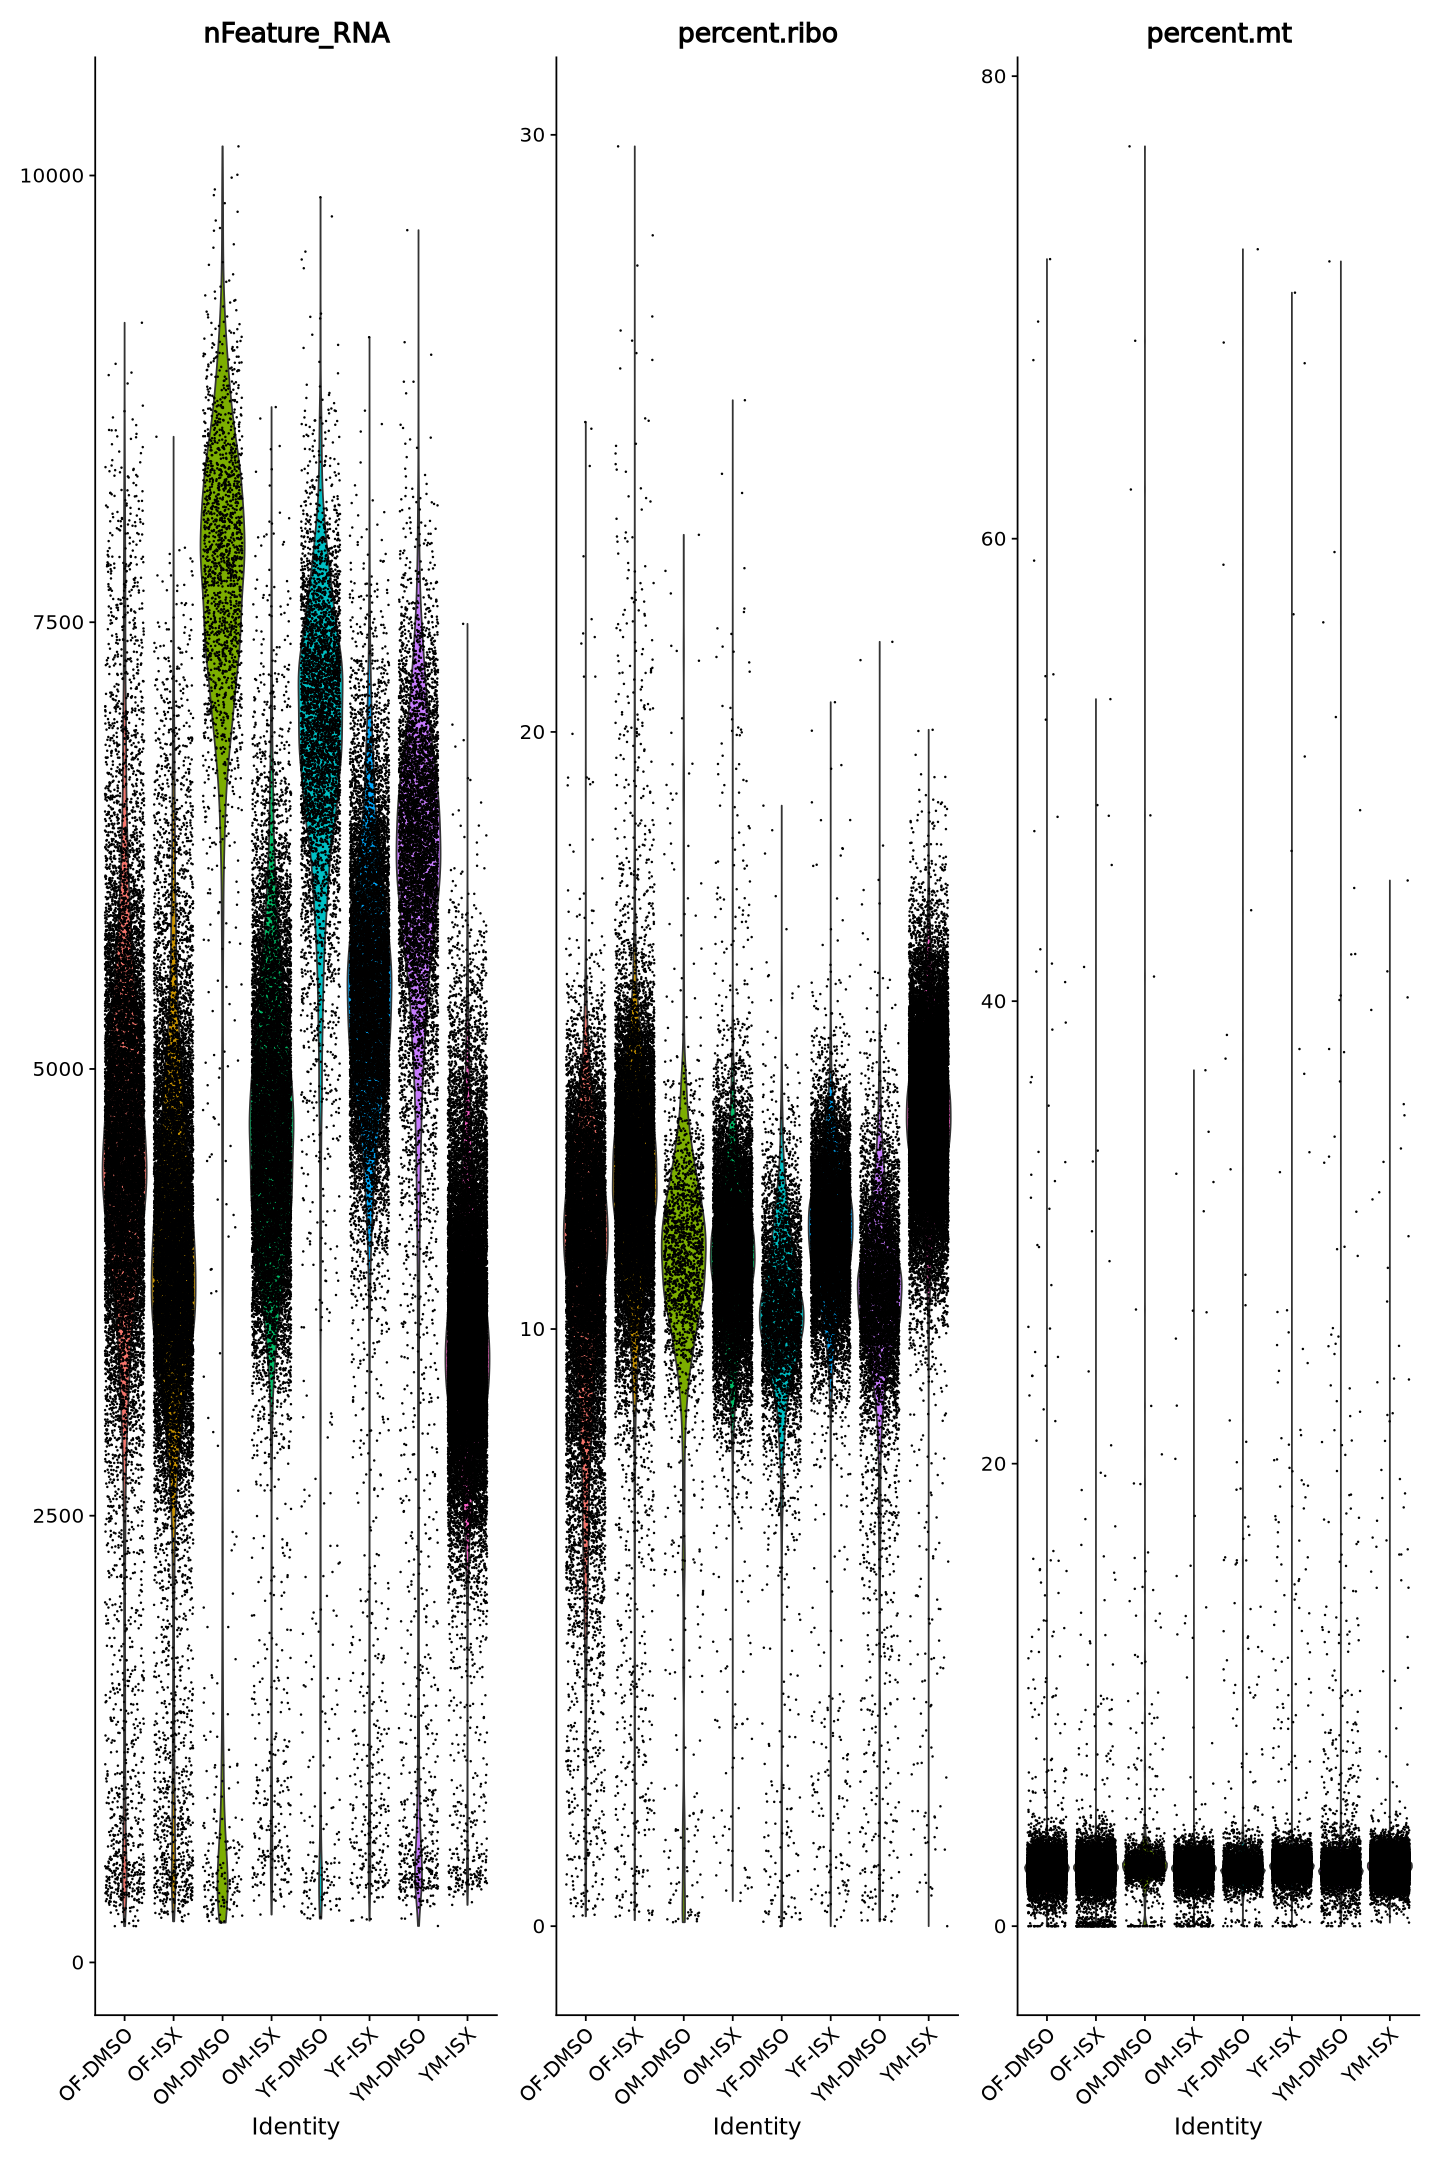

In [8]:
options(repr.plot.width=12, repr.plot.height=18)
#pdf("QC_VlnPlot.pdf",  height = 14, width = 18)
pdf(paste(outDir, "QC_VlnPlot.pdf", sep="/"),  height = 14, width = 18)
VlnPlot<-VlnPlot(seurat_obj, features = c("nFeature_RNA", "percent.ribo", "percent.mt"), ncol = 3)
VlnPlot
dev.off()
VlnPlot

agg_record_2086974990 
                    2

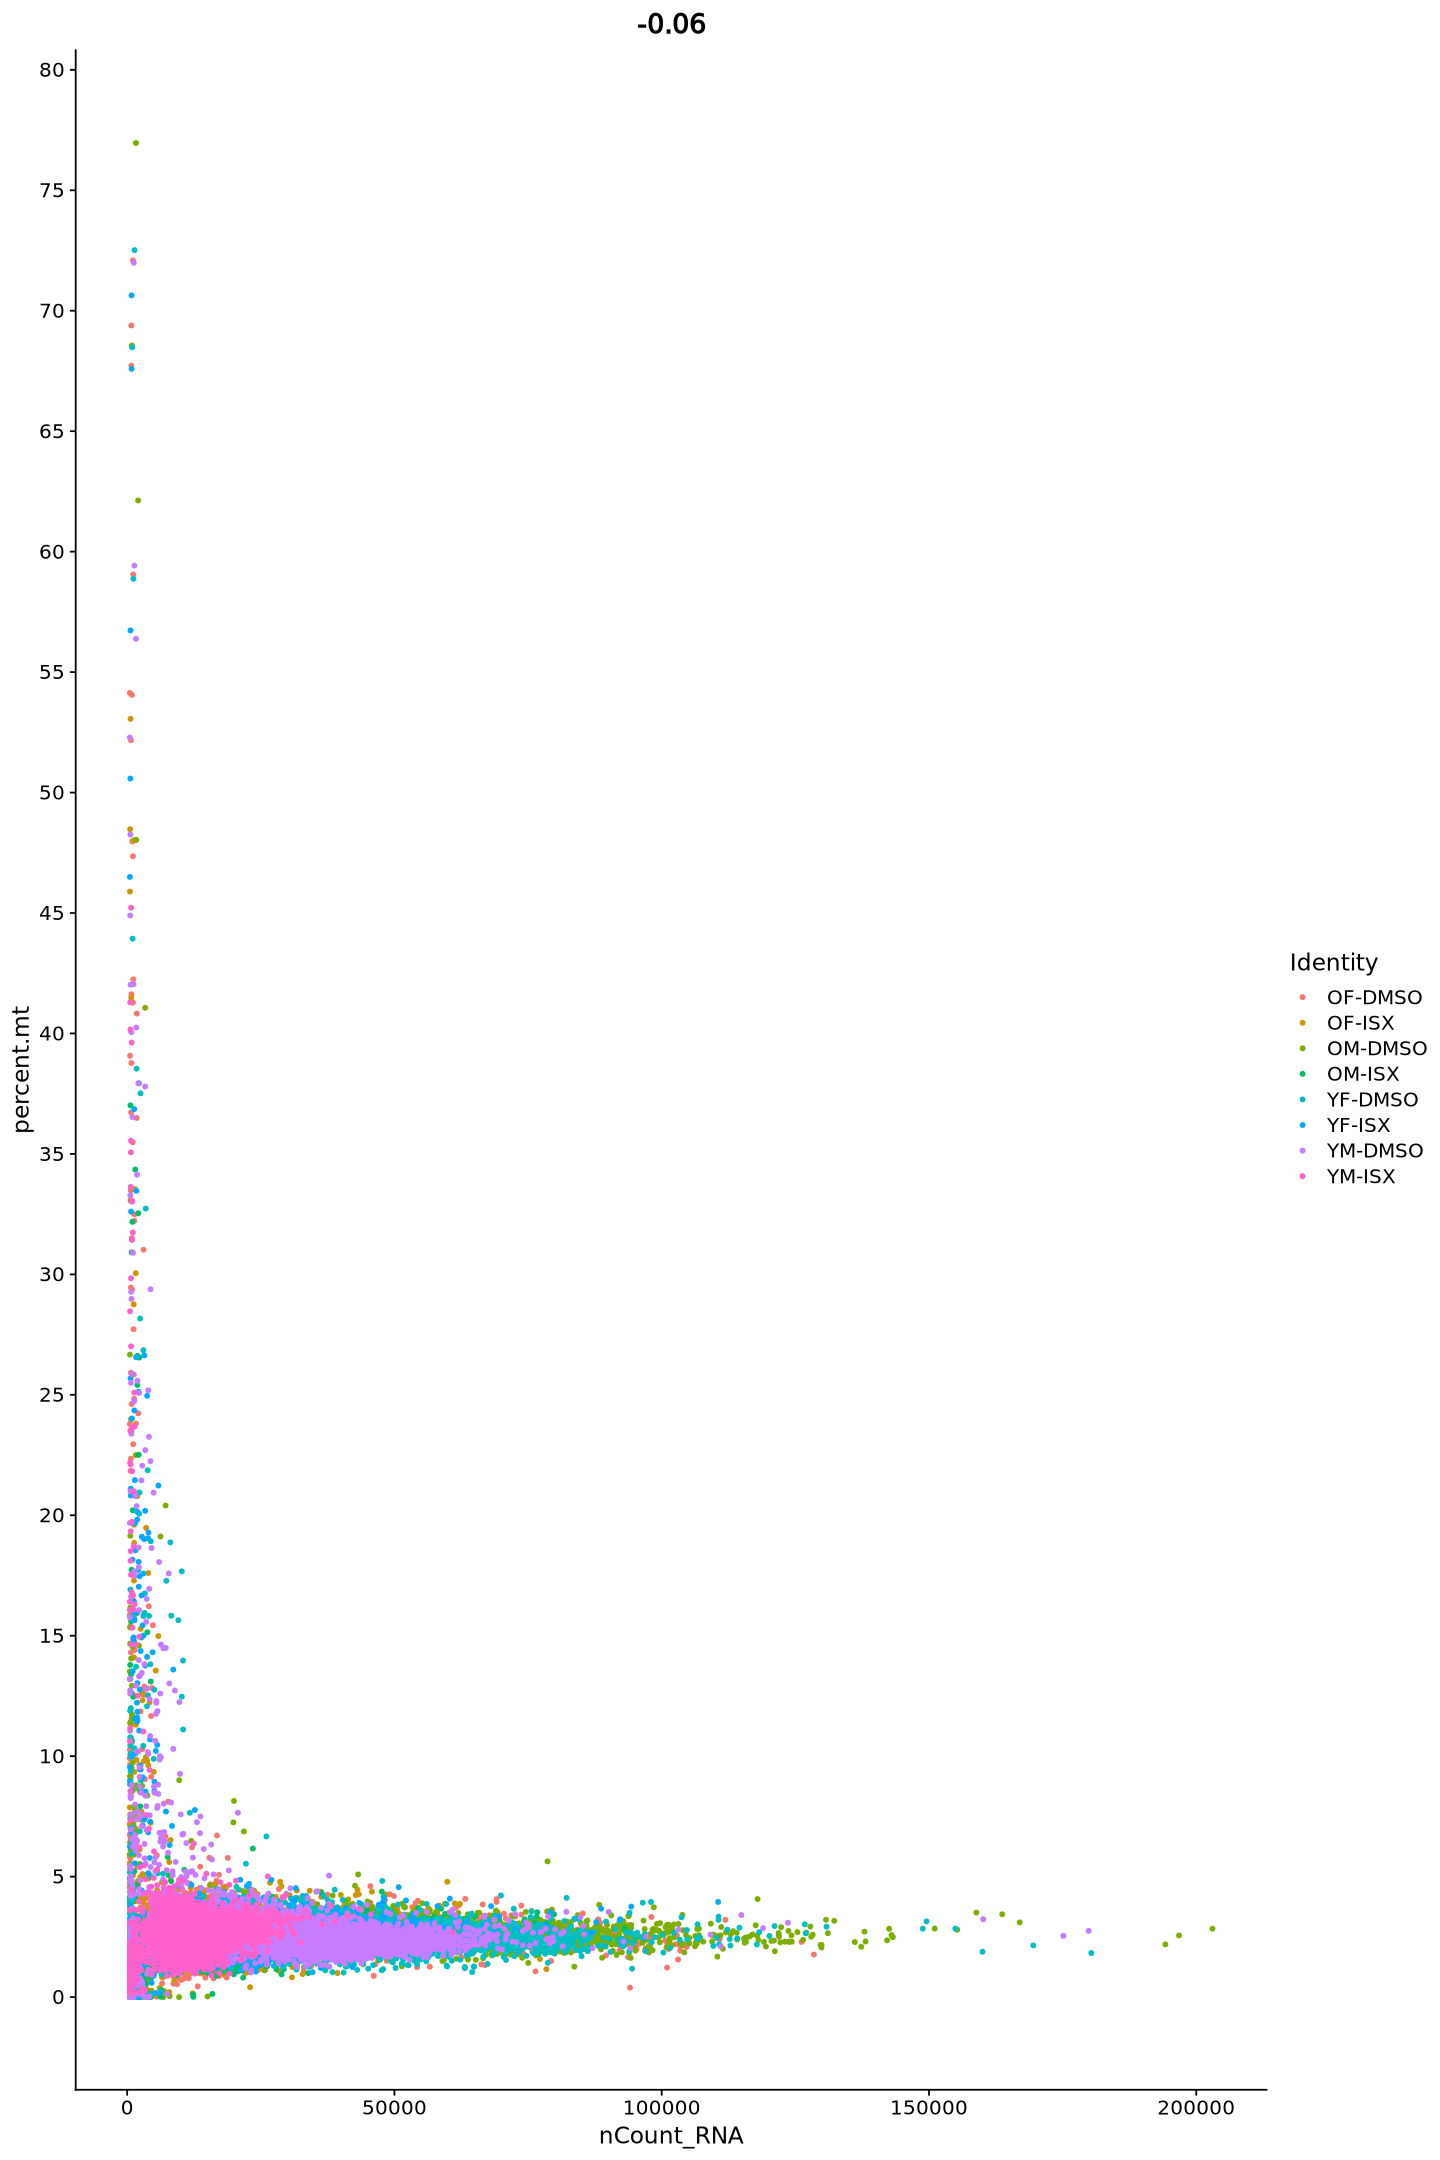

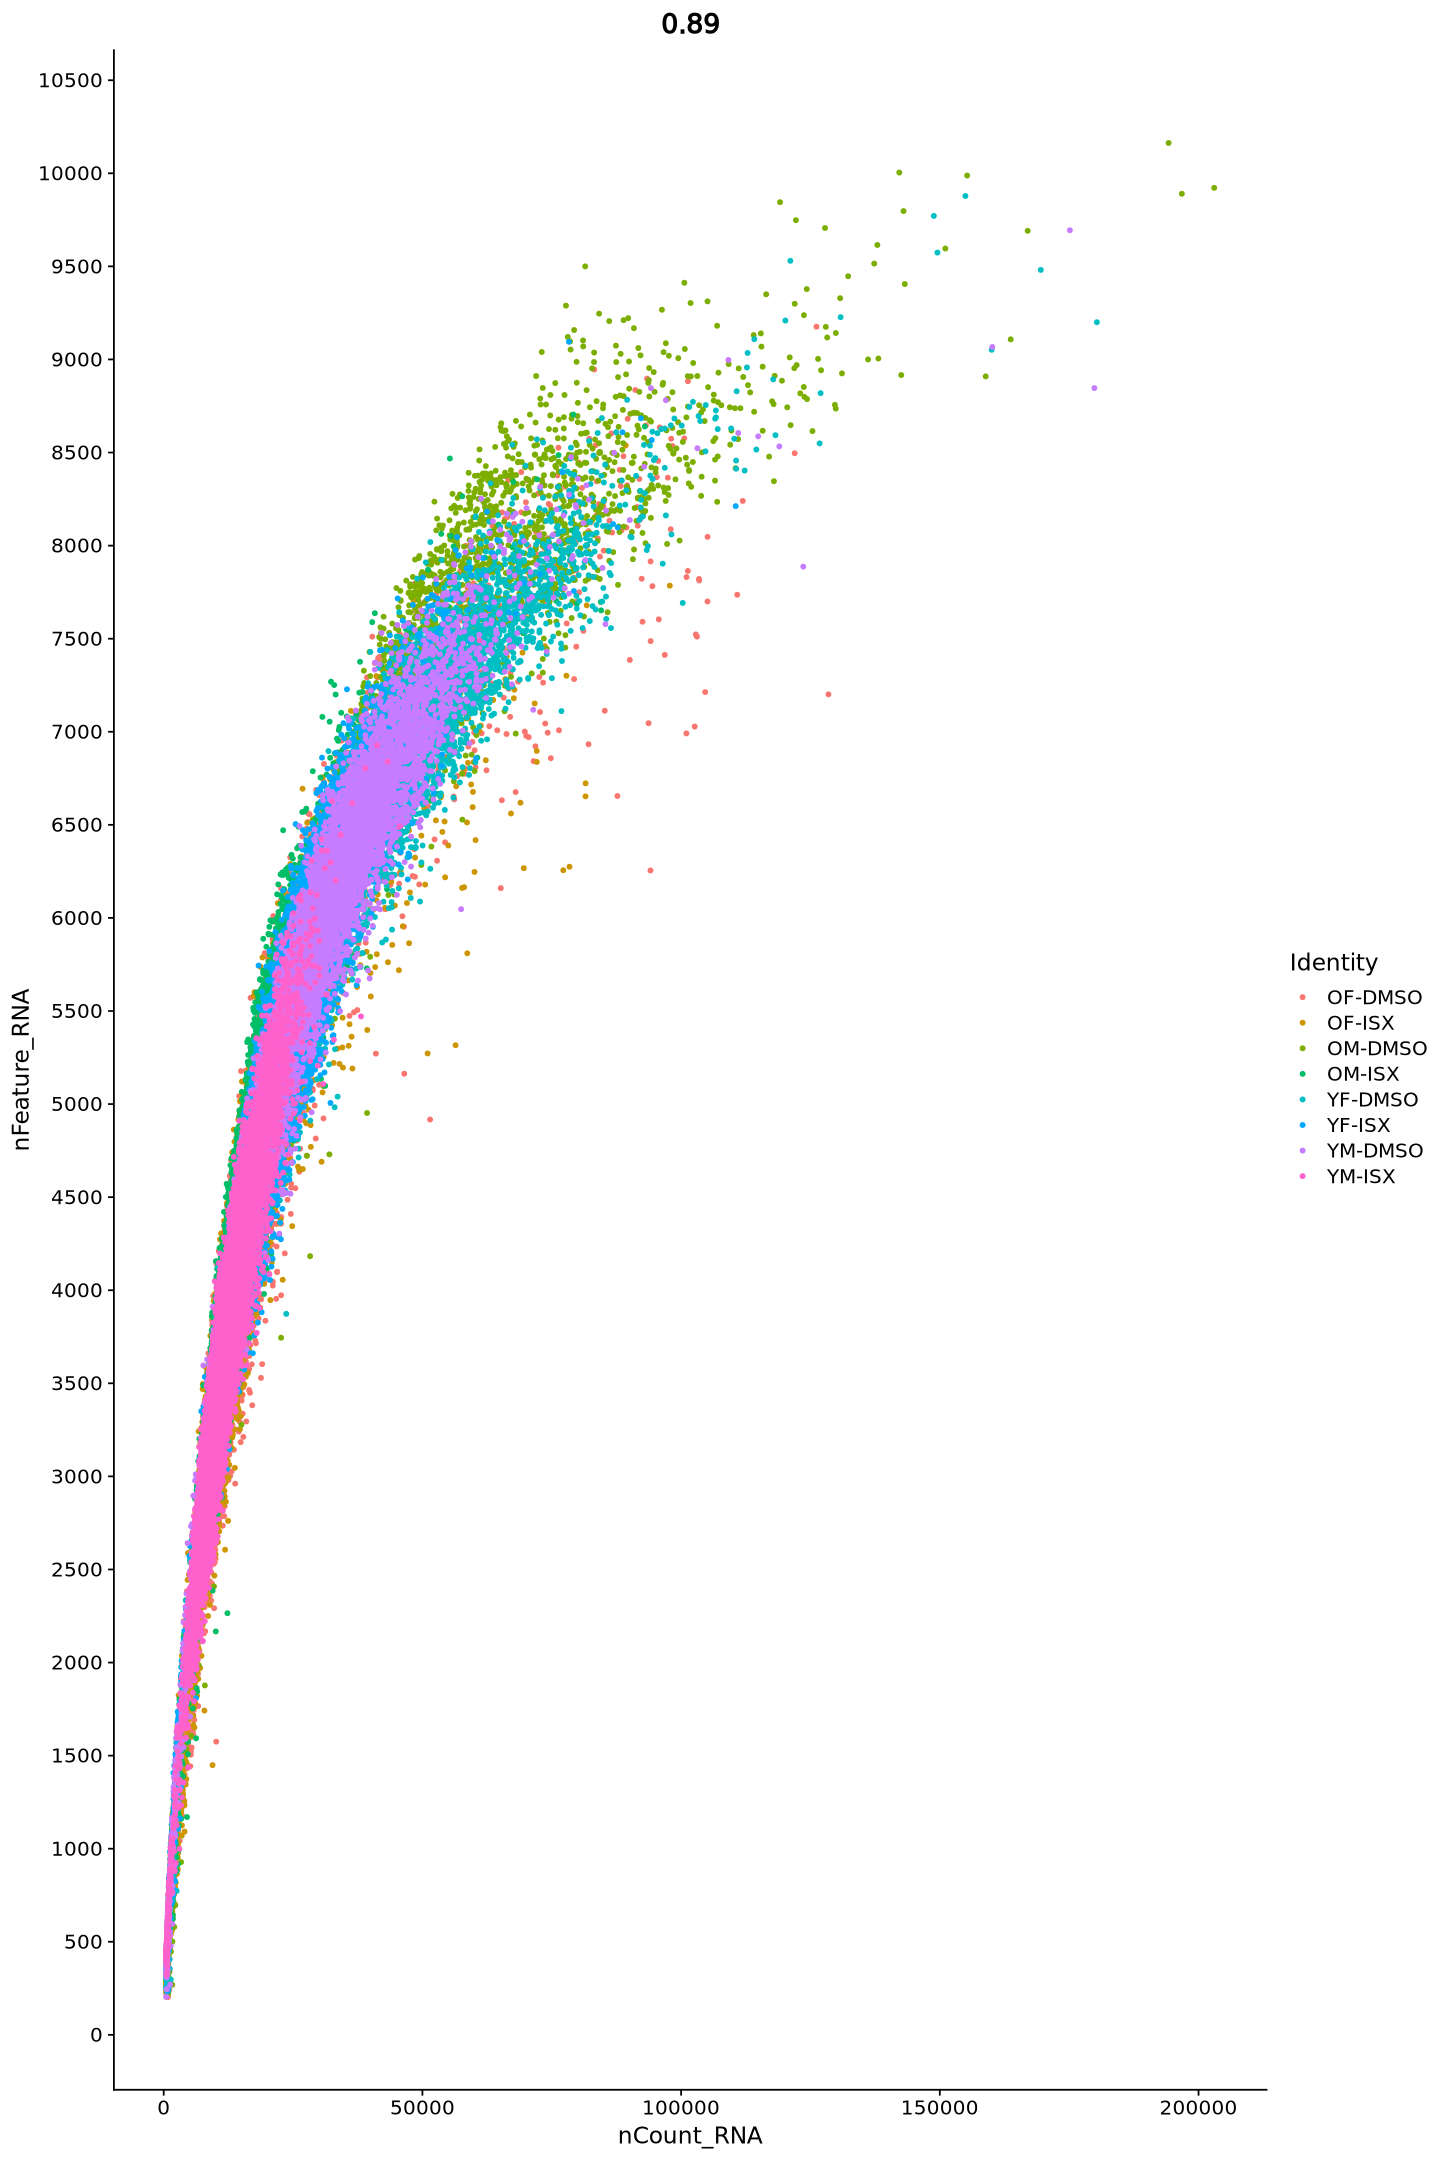

In [9]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
pdf(paste(outDir, "QC_ScatterPlot.pdf", sep="/"),  height = 14, width = 18)
plot1 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") +
    scale_y_continuous(breaks = seq(0, 100, by = 5))
plot2 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") +
    scale_y_continuous(breaks = seq(0, 12000, by = 500))
plot1 + plot2
dev.off()
plot1
plot2

In [10]:
#filtering nFeature_RNA and percent.mt on the basis of the above plots. for percent.mt where we see the "tailing" start
#for nFeature_RNA it is generally where the curve appears to staturate
seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 400 & nFeature_RNA < 8500 
                 & percent.mt < 10)

In [11]:
seurat_list <- SplitObject(seurat_obj, split.by = "orig.ident")

In [12]:
#normalizing data using SCTtransform
vars_to_regress <- c("nCount_RNA", "percent.mt")
system.time(suppressWarnings(seurat_list <- SCTransform(seurat_obj,
                            method = "glmGamPoi",
                            vst.flavor = "v2",
                            vars.to.regress = vars_to_regress, 
                            verbose = FALSE)))

   user  system elapsed 
541.616 140.936 685.670 

In [13]:
#running PCA
seurat_list <- RunPCA(seurat_list, verbose = F)

In [15]:
#finally integrating the data
options(future.globals.maxSize = 100 * 1024^3)
seurat_int <- IntegrateLayers(object = seurat_list, method = RPCAIntegration, normalization.method = "SCT", verbose = FALSE)

In [16]:
#clustering cells by expression
seurat_int <- FindNeighbors(seurat_int, reduction = "integrated.dr", dims = 1:30)
seurat_int <- FindClusters(seurat_int, resolution = 1)
seurat_int <- RunUMAP(seurat_int, dims = 1:30, reduction = "integrated.dr")
save(seurat_int, file="seurat_int_UMAP_20250828.Rdata")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 90152
Number of edges: 2866264

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8458
Number of communities: 23
Elapsed time: 37 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
11:45:31 UMAP embedding parameters a = 0.9922 b = 1.112

11:45:31 Read 90152 rows and found 30 numeric columns

11:45:31 Using Annoy for neighbor search, n_neighbors = 30

11:45:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:45:38 Writing NN index file to temp file /tmp/RtmpG5tQKP/file38594275015011

11:45:38 Searching Annoy index using 1 thread, search_k = 3000

11:46:08 Annoy recall = 100%

11:46:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

In [ ]:
# I save and load the seurat object to preserve the UMAP shape and save on time if any changes are needed in the future
load("seurat_int_UMAP_20250828.Rdata")

agg_record_1809177952 
                    2

agg_record_1809177952 
                    2

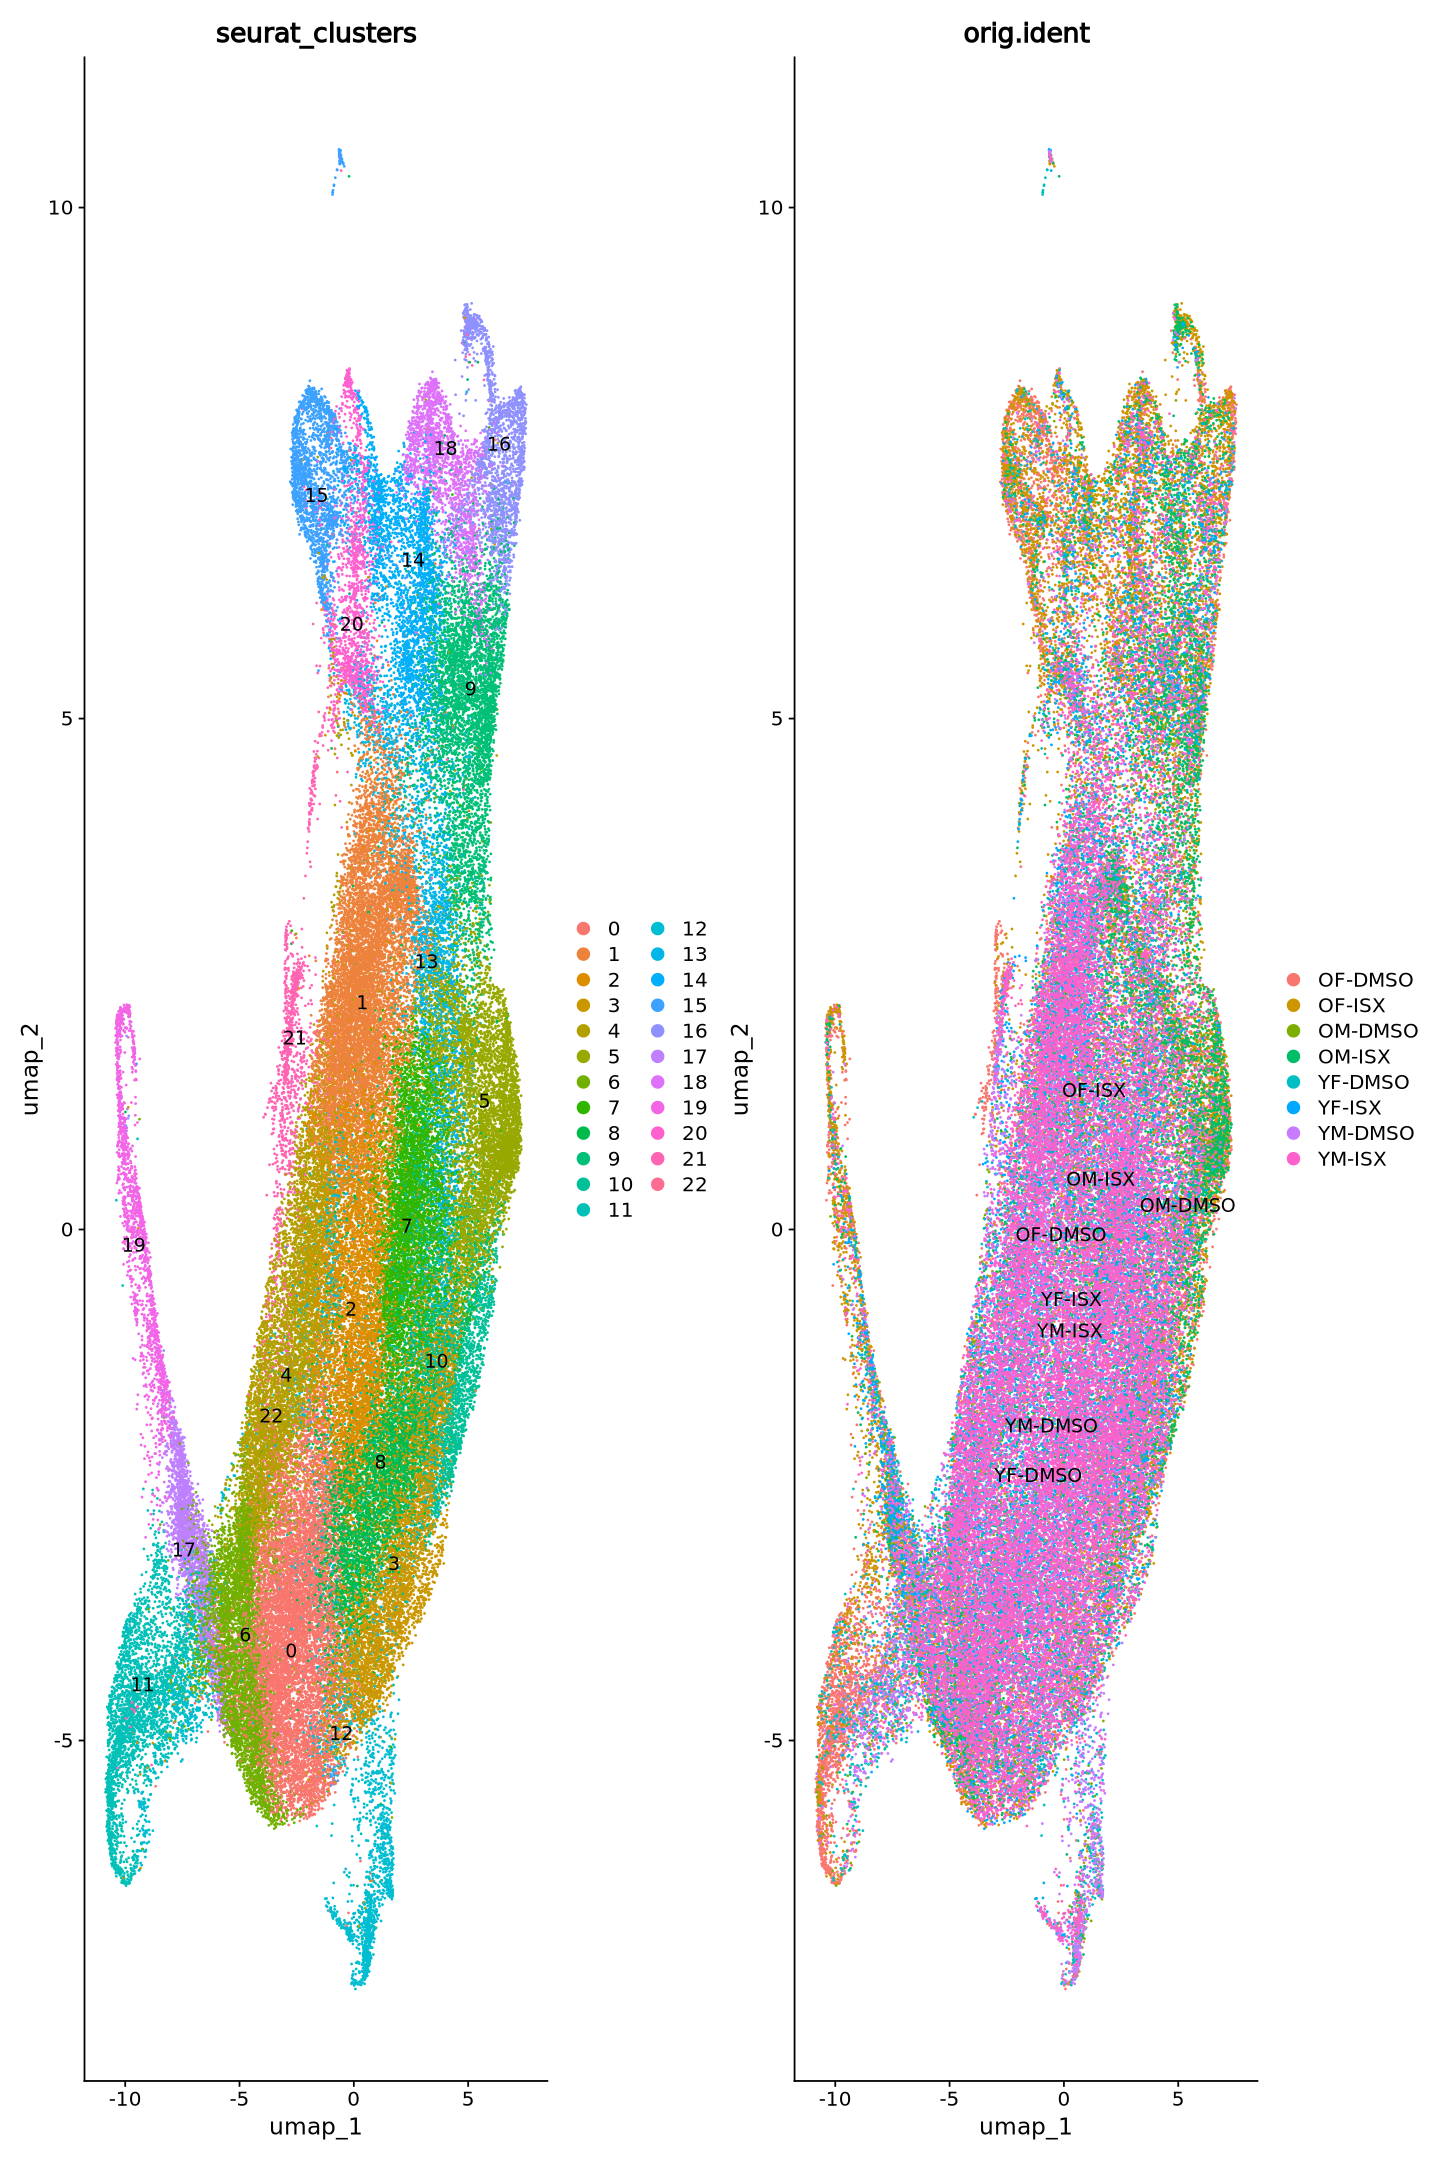

In [17]:
UMAP_byCluster <- DimPlot(seurat_int, label = TRUE, repel = T, group.by="seurat_clusters")
UMAP_byID <- DimPlot(seurat_int, label = TRUE, repel = T, group.by = "orig.ident")
#UMAP_split <- DimPlot(seurat_int, label = TRUE, repel = T, split.by = "orig.ident")

pdf(paste(outDir, "UMAP_byCluster.pdf", sep="/"), height = 14, width = 18)
UMAP_byCluster
dev.off()

pdf(paste(outDir, "UMAP_bySample.pdf", sep="/"), height = 14, width = 18)
UMAP_byID 
dev.off()

#pdf(paste(outDir, "UMAP_split_bySample.pdf", sep="/"))
#UMAP_split
#dev.off()

#view side by side
UMAP_byCluster + UMAP_byID


In [18]:
pdf(paste(outDir, "UMAP_bySample_split.pdf", sep="/"), height = 10, width = 40)
DimPlot(seurat_int, reduction = "umap", split.by = "orig.ident")
dev.off()

agg_record_1235700922 
                    2

In [19]:
seurat_int <- PrepSCTFindMarkers(seurat_int, assay = "SCT", verbose = TRUE)
save(seurat_int, file = "seurat_int_after_PrepSCTFindMarkers_20250828.Rdata")

Found 8 SCT models. Recorrecting SCT counts using minimum median counts: 10715



In [20]:
# Save sessionInfo() to a text file
capture.output(sessionInfo(), file = file.path(outDir, "session_info.txt"))